# Learning Sentiment

Someone else's learned sentiment may note be appropriate for your research. This is a common enough issue when you begin to work in narrow niches (i.e. not what's happening on twitter). 

**How do you go about this?**

The basic workflow is relatively simple.

1. Cut up your text into characteristic chunks that will provide enough context for another reader. 
2. Pull out individual adjectives (and possibly adverbs depending on the writing style) from those chunks.
3. Show the individual adjective and its corresponding text to another party, ask them to rate it on a positive to negative scale (generally -5 to 5). 

A relatively simple process given what we have learned so far.

# Scaling

The harder part is understanding how to scale. 

In theory, the concept is simple - get other people to tell you if a word is positive or negative. The difficult part is figuring out how to access such an audience that will also accept the remuneration you are able to provide.

Crowdsourcing is generally viewed as the answer to constructing a `training` dataset such as this. There a number of such platforms, but the oldest/most oft used is still Amazon's Mechanical Turk. Given that we will work through how to use this service programmatically

# The process of getting set up

Having an account with Amazon where you can buy shampoo and beef jerky is insufficient to use Mechanical Turk. MT resides (more or less) as a part of its enterprise services (which are labelled AWS-Amazon Web Services). To be able to be a requester on MT you must:

1. Sign up for an AWS account (aws.amazon.com)
2. Sign up for an MTurk requester account (requester.mturk.com)
3. Link Your MTurk account to your aws account (https://requester.mturk.com/developer)
4. Sign up for MTurk Sandbox, which is where you can test your forms without paying actual people (requestersandbox.mturk.com) an dlink your sandbox to the aws account (requestersandbox.mturk.com/developer)
5. Set up the IAM (Identity and Access Management) User

# Installation and basic AWS Access

Fortunately, there is a python package to manage access to AWS (boto3). First you will need to install this package with pip

In [1]:
!pip install boto3

    100% |████████████████████████████████| 133kB 1.9MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 3.0MB/s ta 0:00:011
    100% |████████████████████████████████| 4.1MB 166kB/s eta 0:00:01


Then you will need to configure a credentials file that goes in your user directory (`~/.aws/credentials`) with your IAM account credentials. The `credentials` file should be structured as:

<pre>
[default]
aws_access_key_id = YOUR_KEY
aws_secret_access_key = YOUR_SECRET
</pre>

Then set up a configuration file to tell Amazon which region you want your services to be started in (`~/.aws/config`)?

<pre>
[default]
region=us-east-1
</pre>

And then you can check your sandbox balance

In [9]:
import boto3

MTURK_SANDBOX = 'https://mturk-requester-sandbox.us-east-1.amazonaws.com'

mturk = boto3.client('mturk', endpoint_url = MTURK_SANDBOX)

In [10]:
#Should have 10,000 available
print("Available sandbox balance: {0}".format(mturk.get_account_balance()['AvailableBalance']))

Avaiable sandbox balance: 10000.00


If you instead want to connect to your actual MTurk account and marketplace, you can just leave out the endpoint url

In [11]:
real_mturk = boto3.client('mturk')
print("My real money: {0}".format(real_mturk.get_account_balance()['AvailableBalance']))

My real money: 9.90


But I don't want to actually pay money yet

In [12]:
del real_mturk

# Terminology

**Worker**: Anyone on the other side of the MTurk marketplace. Workers can view all open assignments and choose which ones to work on.

**HIT**: Human Intelligence Task - the single unit of work that a Turker would accept. This HIT could be a single task (i.e. "What is in this image") or a series of tasks (although that will increase length of time to complete and pay should scale with that factor). For the sake of further discussion we will say that labelling 1 word is 1 HIT and you have 100 words you want to label.

**Assignment**: Number of workers that should complete each HIT. If you set Assignment to 2 for 100 word HITs, then you would have 200 assignments. You will want to have an assignment of 3 or more when labelling words to increase confidence in the assigned score.

# Hit coding

Hits are ::drumroll please::.....HTML templates :( (Technically it is a HTML page that will be wrapped inside XML, so that's why we save it as `xml`)

That's right, you'll need to create a HTML page for your HIT that will be submitted. In its most basic form, it is relatively simple.

To make life easier, I separate this into 3 parts: `turk_hit_frontmatter.xml`, `turk_question.html`,`turk_hit_backmatter.xml`. The reason is that you can open the `html` page in a browser and see the result directly.

Then to make the final document to submit to AWS, it's just concatenating frontmatter, question, and backmatter to a new file (`backmatter` and `frontmatter` are constant). This front and back matter to the document is pretty simple too.

In [15]:
print(open('turk_hit_frontmatter.xml').read())
print('----00000 Not in File 00000-------')
print(open('turk_hit_backmatter.xml').read())

<HTMLQuestion xmlns="http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/2011-11-11/HTMLQuestion.xsd">
<HTMLContent><![CDATA[

----00000 Not in File 00000-------
]]>
</HTMLContent>
<FrameHeight>600</FrameHeight>
</HTMLQuestion>



And I've coded the simplest turk question possible to pair it with.

In [17]:
!open turk_question.html

Constructing the final, submittable question is then relatively simple - it's just putting the three files together into one.

In [48]:
def construct_turk_xml(turk_html):
    fulltext = open('turk_hit_frontmatter.xml').read() + open(turk_html).read() + \
               open('turk_hit_backmatter.xml').read()
    return fulltext
        
fulltext = construct_turk_xml('turk_question.html')

Now that the task creation is done, we can move to submitting the task.

In [49]:
new_hit = mturk.create_hit(
    Title = 'Is the following word positive, neutral, or negative in emotion?',
    Description = 'Read the passage and click the button for the emotion that is attached to the bolded word',
    Keywords = 'text, quick, labeling',
    Reward = '0.01',
    MaxAssignments = 1,
    LifetimeInSeconds = 172800,
    AssignmentDurationInSeconds = 600,
    AutoApprovalDelayInSeconds = 10,
    Question = fulltext,
)

print( "https://workersandbox.mturk.com/mturk/preview?groupId=" + new_hit['HIT']['HITGroupId'] )
print( "HITID = " + new_hit['HIT']['HITId'] + " (Use to Get Results)" )

https://workersandbox.mturk.com/mturk/preview?groupId=3A0F9TXODVNG70NJNMKNP5M1QV1JOJ
HITID = 3FTID4TN8KXXR4H9EPVOXTCBW7LYL4 (Use to Get Results)


The fields mostly speak for themselves at the start. 

The reward is how much you will pay in USD cents (so this task is for 15 cents).

MaxAssignments is the number of turkers you want to complete the HIT

LifetimeInSeconds - how long the HIT should be available on the MTurk marketplace

AssignmentDurationInSeconds - how long the turker has to complete the HIT once they start the task

AutoApprovalDelayInSeconds - You have the ability to manually approve/deny a turker's work (which determines if the worker gets paid). This threshold sets when the system will move from manual to automatic approval (so that if you forget, the turker still gets paid). Note - requesters are rated on a separate forum for turkers and promptness of paying is one attribute that they track. Don't forget about paying in a reasonable amount of time, especially for low cost/risk tasks.

Question - what you want them to answer.

You can go check out the HIT at the sandbox link (need to register as a turker)

**Excellent**

Now (that I have most likely completed my own HIT), we should now be able to pull the data.

All will we will need is the client connection to MTurk and the HITID for our task.

In [63]:
worker_results = mturk.list_assignments_for_hit(HITId=new_hit['HIT']['HITId'])
worker_results

{'Assignments': [{'AcceptTime': datetime.datetime(2018, 1, 30, 16, 42, 11, tzinfo=tzlocal()),
   'Answer': '<?xml version="1.0" encoding="ASCII"?><QuestionFormAnswers xmlns="http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/2005-10-01/QuestionFormAnswers.xsd"><Answer><QuestionIdentifier>reported_emotion</QuestionIdentifier><FreeText>negative</FreeText></Answer></QuestionFormAnswers>',
   'AssignmentId': '33JKGHPFYCUP77TAX1SU49O93NPNMN',
   'AssignmentStatus': 'Submitted',
   'AutoApprovalTime': datetime.datetime(2018, 1, 30, 16, 42, 24, tzinfo=tzlocal()),
   'HITId': '3FTID4TN8KXXR4H9EPVOXTCBW7LYL4',
   'SubmitTime': datetime.datetime(2018, 1, 30, 16, 42, 14, tzinfo=tzlocal()),
   'WorkerId': 'A2NWOX0S472V5'}],
 'NextToken': 'p1:VyseaX/aFy+NGePOPxkuAa5807QioJgFwOZgzThfaEobNij6kk5heellqdCMFg==',
 'NumResults': 1,
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '660',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 30 Jan 2018 22:42:51 GMT',
   'x

And my answer is inside the assignments list:

In [64]:
worker_results['Assignments'][0]

{'AcceptTime': datetime.datetime(2018, 1, 30, 16, 42, 11, tzinfo=tzlocal()),
 'Answer': '<?xml version="1.0" encoding="ASCII"?><QuestionFormAnswers xmlns="http://mechanicalturk.amazonaws.com/AWSMechanicalTurkDataSchemas/2005-10-01/QuestionFormAnswers.xsd"><Answer><QuestionIdentifier>reported_emotion</QuestionIdentifier><FreeText>negative</FreeText></Answer></QuestionFormAnswers>',
 'AssignmentId': '33JKGHPFYCUP77TAX1SU49O93NPNMN',
 'AssignmentStatus': 'Submitted',
 'AutoApprovalTime': datetime.datetime(2018, 1, 30, 16, 42, 24, tzinfo=tzlocal()),
 'HITId': '3FTID4TN8KXXR4H9EPVOXTCBW7LYL4',
 'SubmitTime': datetime.datetime(2018, 1, 30, 16, 42, 14, tzinfo=tzlocal()),
 'WorkerId': 'A2NWOX0S472V5'}

And now we see something ugly - the answer is in the `Answer` field, but it's in XML! 

Fortunately we can just install the `xmltodict` package which will convert the data out of xml and into something that's friendlier for our purposes.

In [41]:
!pip install xmltodict

In [65]:
import xmltodict

xml_doc = xmltodict.parse(worker_results['Assignments'][0]['Answer'])
xml_doc['QuestionFormAnswers']['Answer']

OrderedDict([('QuestionIdentifier', 'reported_emotion'),
             ('FreeText', 'negative')])

And there we go! We have our answer - the turker thinks that **unkindly** is *negative*

I will leave as an exercise for the reader to figure out how to automatically fill the html template with the passage and word of interest (Hint: manipulate it as a string in python)

# Accounting for error in our estimates

You will now have multiple values for the valence of each word. There are number of ways to handle and process this data. 

For extemely small or large *n* I am confident that you are well-versed in how to reduce this to a single value (take the mean, check for outliers, etc. - up to you).

# Estimating quantities the Bayesian way

We can assume that there is a true value of the sentiment for a specific word in a single context. We know that the responses, and the spread in them, informs our approximation of the real value and accounts for the uncertainty we have in stating that it is the true value. 

When using a Bayesian approach, we are trying to estimate the probability distribution function for the real value (it inherently incorporates uncertainty - which is a good approach when considering something like quantifying the amount of sentiment a word encodes).

The basic idea is that we start with some prior knowledge/distribution of 'truth' for a value and then update it as we receive additional information (i.e. mturk responses). 

<img src='../images/bayes_learn.png'>

Mathematically, we just need to follow bayes rule

$P(A\mbox{ | }B) = \frac{P(B\mbox{ | }A)P(A)}{P(B)}$

or stated in a data-centric way

$P(Model\mbox{ | }Data) = \frac{P(Data\mbox{ | }Model)P(Model)}{P(Data)}$

where the $P(Model)$ is prior probability for our model and $P(Model\mbox{ | }Data)$ is our posterior probability after we have incorporated the data. $P(Data\mbox{ | }Model)$ is simply the probability of observing the data given our current model and $P(Data)$ is the marginal likelihood (which is the same for all models under consideration).

# Sounds complicated?

Fortunately, it's not that hard in practice. There are two ways to go about this - the first that I want you to explore is by hand with scipy.

In [131]:
import scipy.stats as st
import numpy as np

#Set the likelihood
likelihood = np.array([])
#Set our supports
params = np.linspace(-6, 6, 1201)
#And initialize the posterior
posterior = np.array([])
#Construct the prior
prior_sample = np.random.normal(0, 0.2)
prior = np.array([np.product(st.norm.pdf(prior_sample, p)) for p in params])
prior = prior / np.sum(prior)

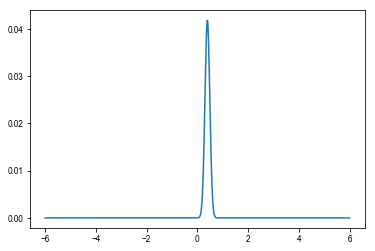

In [143]:
def update_probability(datapoint, likelihood, prior, posterior, params):
    likelihood = np.array([np.product(st.norm.pdf([datapoint], p)) for p in params])
    #Construct the posterior
    tposterior = [prior[i] * likelihood[i] for i in range(prior.shape[0])]
    posterior = tposterior / np.sum(tposterior)
    #Reset the prior to the new posterior
    prior = np.copy(posterior)
    return likelihood, prior, posterior

for i in range(100):
    likelihood, prior, posterior = update_probability(0.4, likelihood, prior, posterior, params)
plt.plot(params, posterior)

Alternatively, you could use a package that implements Bayesian data fitting (such as pymc or emcee), instead of coding it yourself to estimate the parameters.